## Preperations
Loading libraries and the data

In [1]:
import pandas as pd
from pathlib import Path
from sklearn.decomposition import PCA
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.preprocessing import StandardScaler
import datetime

import os, math

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
# Preprocessing
from sklearn.preprocessing import MinMaxScaler
# Algorithms
from minisom import MiniSom
from tslearn.barycenters import dtw_barycenter_averaging
from tslearn.clustering import TimeSeriesKMeans, KernelKMeans, silhouette_score
from sklearn.cluster import KMeans, DBSCAN, SpectralClustering

In [2]:
with open("IS-thesis-pattern-extraction/options.txt", 'r') as f:
    options = f.readlines()
    options = {option.split("=")[0]: option.split("=")[1].strip() for option in options}
print(options)

{'hanoi_scenario_dir': 'C:\\Users\\mjnst\\Desktop\\Thesis\\Hanoi_CMH\\Scenario-1', 'RUG_dir': 'C:\\Users\\mjnst\\Desktop\\Thesis\\RUG_data_5years', 'RUG_raw_csv': 'C:\\Users\\mjnst\\Desktop\\Thesis\\rug_csv.csv', 'RUG_timeseries': 'C:\\Users\\mjnst\\Desktop\\Thesis\\rug_timeseries.pkl', 'RUG_obfuscated': 'C:\\Users\\mjnst\\Desktop\\Thesis\\obfuscated_data.pkl'}


In [ ]:
# From JSON file
# RUG = pd.read_json(f'{options["RUG_dir"]}/summary.json')
# display(RUG)
# RUG.to_pickle(f'{options["RUG_dir"]}/summary.pkl')

# From pickl file


# RUG = pd.read_csv("rug_csv.csv", nrows=525600*2) #525600 = 1 year
RUG = pd.read_pickle(options['RUG_obfuscated'])

RUG

Problem: if the data ends in a different daylight savings time phase, the function gets confused and errors

In [4]:
# RUG.date = pd.date_range(start = RUG.date.min(), end = RUG.date.max(), freq='min')

# RUG.set_index('date', inplace=True)

### Interpolate data

Limit of 20 consecutive missing values was used 

In [5]:
RUG.interpolate(method='linear', inplace=True, limit=20)

In [6]:

# print(RUG.describe().round(3).T.to_latex())

In [20]:

# split data into groups of timeperiod x (here 1d)
# groups = RUG['Oosterbeek-hoog\Fletcher BV|Supplied'].groupby(pd.Grouper(freq='D'))
groups = RUG['Location 1 - flow'].groupby(pd.Grouper(freq='D'))

# get the calender date of the groups
days = list(groups.first().index.strftime('%Y:%m:%d'))

gro = [groups.get_group(x).reset_index(drop=True) for x in groups.groups]

temp = pd.concat(gro, axis=1, keys=days)

temp.index = pd.date_range("00:00", "23:59", freq="1min").strftime('%H:%M')

# drop all columns of temp dataframe which contain nan values
temp.dropna(axis=1, how='any', inplace=True)

# temp


In [21]:
# reduce data interval to every 10 minutes
temp = temp[::10]

## Scaling

In [22]:
scaled_list = [temp[col] for col in temp]

In [23]:
for i in range(len(scaled_list)):
    scaler = MinMaxScaler()
    scaled_list[i] = MinMaxScaler().fit_transform(scaled_list[i].to_numpy().reshape(-1, 1))
    scaled_list[i]= scaled_list[i].reshape(len(scaled_list[i]))

scaled_list = np.nan_to_num(scaled_list, copy=False, nan=0.0)
scaled_list

array([[0.70603275, 0.64161591, 0.90574834, ..., 0.49675201, 0.63894582,
        0.83360089],
       [0.86276017, 0.93066211, 0.93648442, ..., 0.51124989, 0.39492303,
        0.10629402],
       [0.15283021, 0.045564  , 0.28552957, ..., 0.42100006, 0.33756503,
        0.15943394],
       ...,
       [0.07818467, 0.35156901, 0.34698459, ..., 0.61569603, 0.59528091,
        0.40617031],
       [0.31527744, 0.29096752, 0.13839464, ..., 0.75221194, 0.37071619,
        0.42673396],
       [0.41205551, 0.32673779, 0.30190697, ..., 0.46907498, 0.35677434,
        0.29942733]])

## Clustering

### Self Organizing Maps (SOM)

In [ ]:
som_x = som_y = math.ceil(math.sqrt(math.sqrt(len(scaled_list))))
# I didn't see its significance but to make the map square,
# I calculated square root of map size which is 
# the square root of the number of series
# for the row and column counts of som

som = MiniSom(som_x, som_y,len(scaled_list[0]), sigma=0.3, learning_rate = 0.1)

som.random_weights_init(scaled_list)
som.train(scaled_list, 50000)

In [ ]:
# Little handy function to plot series
def plot_som_series_averaged_center(som_x, som_y, win_map):
    fig, axs = plt.subplots(som_x,som_y,figsize=(20,20))
    fig.suptitle('Clusters')
    for x in range(som_x):
        for y in range(som_y):
            cluster = (x,y)
            if cluster in win_map.keys():
                for series in win_map[cluster]:
                    axs[cluster].plot(series,c="gray",alpha=0.5) 
                axs[cluster].plot(np.average(np.vstack(win_map[cluster]),axis=0),c="red")
            cluster_number = x*som_y+y+1
            axs[cluster].set_title(f"Cluster {cluster_number}")

    plt.show()

In [ ]:
win_map = som.win_map(scaled_list)
# Returns the mapping of the winner nodes and inputs

plot_som_series_averaged_center(som_x, som_y, win_map)

In [ ]:

cluster_c = []
cluster_n = []
for x in range(som_x):
    for y in range(som_y):
        cluster = (x,y)
        if cluster in win_map.keys():
            cluster_c.append(len(win_map[cluster]))
        else:
            cluster_c.append(0)
        cluster_number = x*som_y+y+1
        cluster_n.append(f"Cluster {cluster_number}")

plt.figure(figsize=(25,5))
plt.title("Cluster Distribution for SOM")
plt.bar(cluster_n,cluster_c)
plt.show()

### Time Series K-Means (TSK)

In [ ]:
cluster_count = math.ceil(math.sqrt(len(scaled_list))) 
# A good rule of thumb is choosing k as the square root of the number of points in the training data set in kNN

km = TimeSeriesKMeans(n_clusters=cluster_count, metric="dtw", n_jobs=-1)

labels = km.fit_predict(scaled_list)

In [ ]:
plot_count = math.ceil(math.sqrt(cluster_count))

fig, axs = plt.subplots(plot_count,plot_count,figsize=(25,25))
fig.suptitle('Clusters')
row_i=0
column_j=0
# For each label there is,
# plots every series with that label
for label in set(labels):
    cluster = []
    for i in range(len(labels)):
            if(labels[i]==label):
                axs[row_i, column_j].plot(scaled_list[i],c="gray",alpha=0.4)
                cluster.append(scaled_list[i])
    if len(cluster) > 0:
        axs[row_i, column_j].plot(np.average(np.vstack(cluster),axis=0),c="red")
    axs[row_i, column_j].set_title("Cluster "+str(row_i*som_y+column_j))
    column_j+=1
    if column_j%plot_count == 0:
        row_i+=1
        column_j=0
        
plt.show()

### Kernal K-Means (KKM)

In [ ]:
cluster_count = math.ceil(math.sqrt(len(scaled_list))) 

In [ ]:

# A good rule of thumb is choosing k as the square root of the number of points in the training data set in kNN

gak_km = KernelKMeans(n_jobs=-1)

labels_gak_km = gak_km.fit_predict(scaled_list)

In [ ]:
plot_count = math.ceil(math.sqrt(cluster_count))

fig, axs = plt.subplots(plot_count,plot_count,figsize=(25,25))
fig.suptitle('Clusters')
row_i=0
column_j=0
# For each label there is,
# plots every series with that label
for label in set(labels_gak_km):
    cluster = []
    for i in range(len(labels_gak_km)):
            if(labels_gak_km[i]==label):
                axs[row_i, column_j].plot(scaled_list[i],c="gray",alpha=0.4)
                cluster.append(scaled_list[i])
    if len(cluster) > 0:
        axs[row_i, column_j].plot(np.average(np.vstack(cluster),axis=0),c="red")
    axs[row_i, column_j].set_title("Cluster "+str(row_i*som_y+column_j))
    column_j+=1
    if column_j%plot_count == 0:
        row_i+=1
        column_j=0
        
plt.show()

### Principal Component Analysis (PCA)

Shape before PCA:  (2130, 144)
Shape after PCA:  (2130, 5)


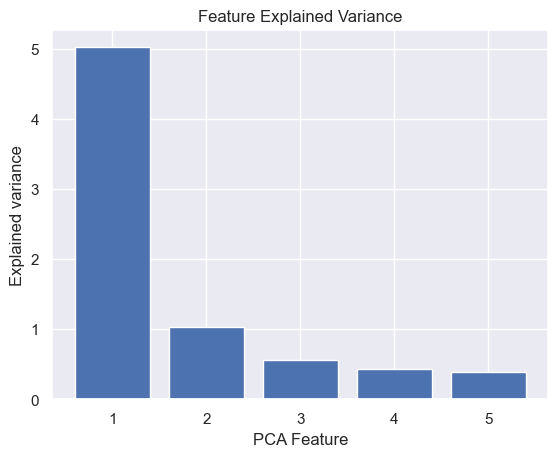

In [28]:
sns.set()
 
# Reduce from 4 to 3 features with PCA
# pca = PCA(n_components=cluster_count)
pca = PCA(n_components=0.80, svd_solver='full')
# pca = PCA(n_components=2, svd_solver='full')
 
# Fit and transform data
pca_features = pca.fit_transform(scaled_list)
 

print('Shape before PCA: ', scaled_list.shape)
print('Shape after PCA: ', pca_features.shape)

pca_df = pd.DataFrame(
    data=pca_features)

# Bar plot of explained_variance
plt.bar(
    range(1,len(pca.explained_variance_)+1),
    pca.explained_variance_
    )
 
 
plt.xlabel('PCA Feature')
plt.ylabel('Explained variance')
plt.title('Feature Explained Variance')
plt.show()

Text(0.5, 1.0, 'Scree Plot')

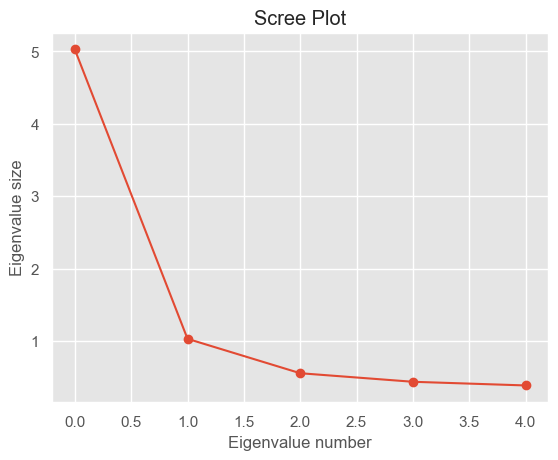

In [29]:
import matplotlib.pyplot as plt
plt.style.use("ggplot") 
plt.plot(pca.explained_variance_, marker='o')
plt.xlabel("Eigenvalue number")
plt.ylabel("Eigenvalue size")
plt.title("Scree Plot")

### PCA and K-Means

In [30]:
from tqdm import tqdm, trange

In [39]:
wcss = []
silhouette_scores = []
for i in trange(1,10):
    kmeans_pca = TimeSeriesKMeans(n_clusters=i, metric="dtw", n_jobs=-1).fit(pca_features)
    wcss.append(kmeans_pca.inertia_)
    print("silhouette_score")
    try:
        silhouette_scores.append(silhouette_score(pca_features, kmeans_pca.labels_, n_jobs=-1))
    except:
        silhouette_scores.append(0)

  0%|          | 0/9 [00:00<?, ?it/s]

silhouette_score


 11%|█         | 1/9 [03:30<28:07, 210.96s/it]

silhouette_score


 22%|██▏       | 2/9 [06:44<23:25, 200.73s/it]

silhouette_score


 33%|███▎      | 3/9 [09:40<18:56, 189.38s/it]

silhouette_score


 44%|████▍     | 4/9 [12:47<15:41, 188.35s/it]

silhouette_score


 56%|█████▌    | 5/9 [16:03<12:45, 191.35s/it]

silhouette_score


 67%|██████▋   | 6/9 [22:07<12:30, 250.06s/it]

silhouette_score


 78%|███████▊  | 7/9 [26:25<08:25, 252.63s/it]

silhouette_score


 89%|████████▉ | 8/9 [30:59<04:19, 259.29s/it]

silhouette_score


100%|██████████| 9/9 [36:06<00:00, 240.73s/it]


Text(0.5, 0, 'Number of clusters')

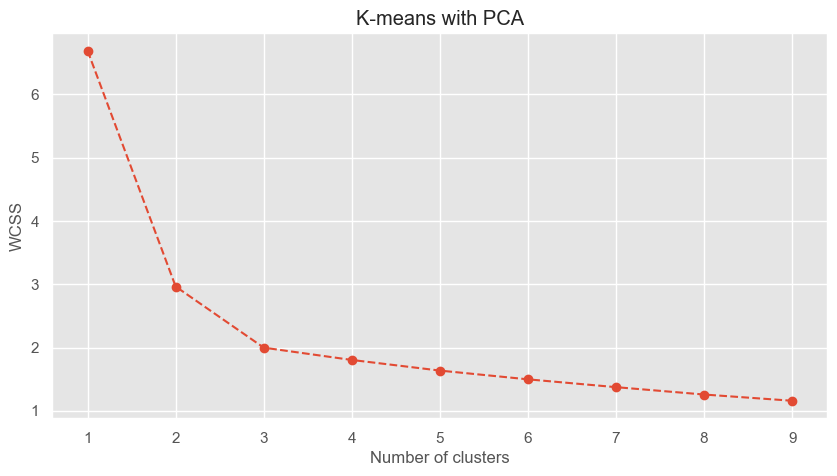

In [40]:
plt.figure(figsize=(10,5))
plt.plot(range(1,10), wcss, marker='o', linestyle='--')
plt.title('K-means with PCA')
plt.ylabel('WCSS')
plt.xlabel('Number of clusters')


Text(0.5, 0, 'Number of clusters')

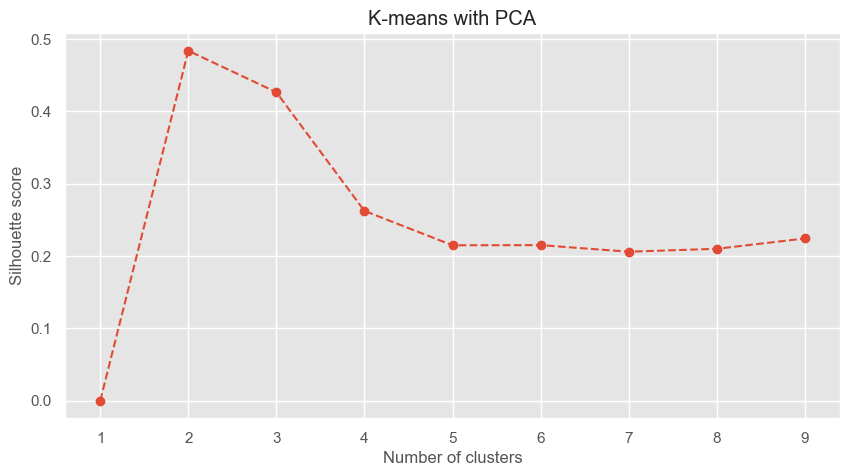

In [42]:
plt.figure(figsize=(10,5))
plt.plot(range(1,10), silhouette_scores, marker='o', linestyle='--')
plt.title('K-means with PCA')
plt.ylabel('Silhouette score')
plt.xlabel('Number of clusters')


In [ ]:
from collections import Counter
kmeans_pca = TimeSeriesKMeans(n_clusters=6, metric="dtw", n_jobs=-1).fit(pca_features)
plt.bar(dict(Counter(kmeans_pca.labels_)).keys(), dict(Counter(kmeans_pca.labels_)).values())


# PCA Kmeans complete

In [ ]:
dataset = [temp[col] for col in temp]

train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size], dataset[train_size:len(dataset)]

# train = train.to_numpy().reshape(-1,1)
# test = test.to_numpy().reshape(-1,1)

# scaler = MinMaxScaler()
# train = scaler.fit_transform(train)
# test = scaler.transform(test)

In [ ]:
sns.set()
 
# Reduce from 4 to 3 features with PCA
pca = PCA(n_components=cluster_count)
 
# Fit and transform data
pca_features = pca.fit_transform(train)
 

print('Shape before PCA: ', scaled_list.shape)
print('Shape after PCA: ', pca_features.shape)

pca_df = pd.DataFrame(
    data=pca_features)

# Bar plot of explained_variance
plt.bar(
    range(1,len(pca.explained_variance_)+1),
    pca.explained_variance_
    )
 
 
plt.xlabel('PCA Feature')
plt.ylabel('Explained variance')
plt.title('Feature Explained Variance')
plt.show()

In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Ridge

scaler_pca = make_pipeline(StandardScaler(), PCA(n_components=2))

X_train_factors = scaler_pca.fit_transform(train)

forecaster = ForecastingChain(
    Ridge(),
    n_estimators=test_size,
    lags=range(1,25),
    use_exog=False,
    n_jobs=-1,
).fit(None, X_train_factors)

y_pred_factors = forecaster.predict(np.arange(test_size))

y_pred = scaler_pca.steps[0][-1].inverse_transform(
    scaler_pca.steps[-1][-1].inverse_transform(y_pred_factors)
)

In [ ]:
plt.bar(dict(Counter(kmeans_pca.labels_)).keys(), dict(Counter(kmeans_pca.labels_)).values())

In [ ]:
kmeans_pca.predict(pca_features_test)